In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pystan
import corner

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

In [28]:
model = '''
data{
    int<lower=0> N;
    real Mobs[N];
    real Munc[N];
}
parameters{
    real mu;
    real<lower=0.> sigma;
    real Mtrue_std[N];
}
transformed parameters{
    real Mtrue[N];
    
    for (n in 1:N)
        Mtrue[n] = mu + sigma * Mtrue_std[n];
}
model{
    mu ~ normal(-1.7, 1.0);
    sigma ~ normal(0.0, 1.0);

    Mobs ~ normal(Mtrue, Munc);
    Mtrue_std ~ normal(0, 1);
}
'''
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b960b7f2add1217303b91f484523bc5d NOW.


In [48]:
npts = 200
rmu = -1.7
rsig = .15
runc = .01 #fractional uncertainty

/home/davies/.local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/davies/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


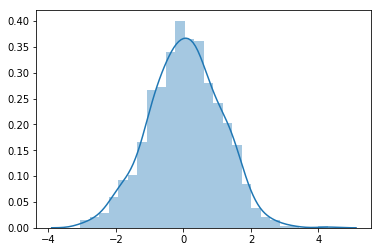

In [49]:
nloops = 1000
mus = np.zeros(nloops)
muer = np.zeros(nloops)
for idx in range(nloops):
    Mtrue = np.random.randn(npts)*rsig + rmu
    Munc = np.abs(Mtrue*runc)
    Mobs = Mtrue + np.random.randn(npts)*Munc
    data = {'N': npts,
           'Mobs':Mobs,
           'Munc':Munc}
    init = {'mu':rmu,
           'sigma':rsig,
           'Mtrue_std': np.zeros(npts)}
    fit = sm.sampling(data=data, iter=1000, chains=2, init=[init, init])
    mus[idx] = np.median(fit['mu'])
    muer[idx] = np.std(fit['mu'])
sns.distplot((mus - rmu) / muer)

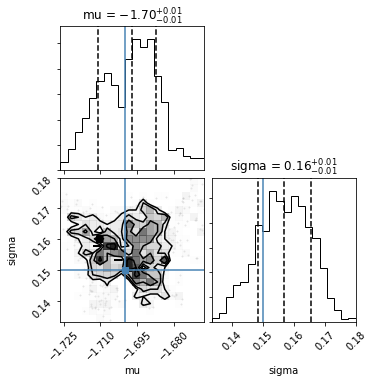

In [50]:
import corner
chain = np.array([fit['mu'],fit['sigma']]).T
truths=[rmu, rsig]
corner.corner(chain,labels=['mu','sigma'],\
                  truths=truths,\
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

In [51]:
print(np.std((mus - rmu) / muer))

1.0589891839569954


In [52]:
print(fit)

Inference for Stan model: anon_model_b960b7f2add1217303b91f484523bc5d.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               -1.7  2.9e-3   0.01  -1.72  -1.71   -1.7  -1.69  -1.68     16   1.06
sigma            0.16  2.2e-3 8.4e-3   0.14   0.15   0.16   0.16   0.17     15   1.17
Mtrue_std[0]     0.34    0.02   0.13   0.09   0.26   0.34   0.42   0.59     43   1.03
Mtrue_std[1]     0.58    0.02   0.13   0.31    0.5   0.58   0.66   0.83     40   1.04
Mtrue_std[2]    -0.05    0.02   0.12   -0.3  -0.14  -0.05   0.03   0.19     52   1.02
Mtrue_std[3]    -1.42    0.03   0.16  -1.72  -1.53  -1.42  -1.32   -1.1     38   1.01
Mtrue_std[4]     0.24    0.02   0.14  -0.01   0.16   0.24   0.33   0.51     45   1.02
Mtrue_std[5]    -0.56    0.02   0.13  -0.81  -0.64  -0.56  -0.47   -0.3     66    1.0
Mtrue_std[6]    -0.34    0.02   0.13   